<a href="https://colab.research.google.com/github/TomYOON/Stock-project/blob/master/Basic_Model_v3_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
#importing data from url

url="https://raw.githubusercontent.com/Concarne2/stock_data/master/DATA/sk%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4(%EC%88%98%EC%A0%95).csv"
csv_df=pd.read_csv(url)

#  0     1    2    3     4      5    6    7
# year,month,day,close,volume,start,high,low


csv_np_raw = csv_df.to_numpy()
row,col = np.shape(csv_np_raw)

for i in range(row):
  for j in range(3,col):
    csv_np_raw[i][j] = csv_np_raw[i][j].replace(",","")

full_data_np = np.flip(csv_np_raw.astype(int),axis=0)
data_np = full_data_np[:,[5,3,6,7,4]]
#data_np = full_data_np[:,[6,3,7,4]]

print(data_np.shape)
#plt.plot(data_np[:,0])

(980, 5)


In [0]:
#normalize data

#data_min = np.min(data_np[:,1])
#data_scale = np.max(data_np[:,1]) - np.min(data_np[:,1])

scaler = MinMaxScaler()
scaler.fit(data_np)
data_norm = scaler.transform(data_np)
data_norm = np.insert(data_norm,0,np.arange(data_norm.shape[0]),axis=1)
#data = torch.from_numpy(data_norm)
#plt.plot(data_norm[:,0])

In [0]:
class MoreBasicLSTM(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class MoreBasicLSTM_timestamp_processing(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    input_without_timestamp = inputs[:,:,1:]
    batch_size = inputs
    
    _,(hidden,_) = self.lstm(input_without_timestamp)
    output = self.drop(hidden.squeeze(0))
    output = self.fclayers(output).squeeze(0)
    print(output.size())
    output = output.view(self.date,1)
    timestamps = torch.from_numpy(np.arange(self.date) + inputs[-1,:,0].item() + 1).view(self.date,1)
    
    return torch.cat([timestamps,output],axis=1)

In [0]:
class LSTM_twolayer(nn.Module):   
  def __init__(self, input_size, hidden, drop, output_size):
    super().__init__()
    self.date = output_size
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden, num_layers = 2, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = output_size)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
class LSTM_sequential(nn.Module):   
  def __init__(self, input_size, hidden, drop):
    super().__init__()
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden, num_layers = 2, dropout = drop)
    self.drop = nn.Dropout(p = drop)
    self.fclayers = nn.Sequential(
        nn.Softsign(),
        nn.Linear(in_features = hidden, out_features = 1)
    )
    
    
  def forward(self, inputs):
    
    _,(hidden,_) = self.lstm(inputs)
    output = self.drop(hidden[1,:,:].squeeze(0))
    output = self.fclayers(output).squeeze(0)
    
    return output

In [0]:
def train(time_steps, date, data_target_batches, model, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  #prediction_list=[]
  batch_amount = len(data_target_batches)
  batch_size = list(data_target_batches[0][0].size())[1]
  model.train()
  
  for data, target in data_target_batches:
    
    assert target[0,0,0].item() == (data[-1,0,0].item() + 1)
    
    optimizer.zero_grad()   
    
    data_without_timestamp = data[:,:,1:].clone()

    all_predictions = []
    
    for d in range(date):
      prediction_batch = model(data_without_timestamp)
      all_predictions.append(prediction_batch)
      data_last = data_without_timestamp[-1:,:,:].clone()
      for b in range(batch_size):
        data_last[0,b,1] = prediction_batch[b].item()  


      data_without_timestamp = torch.cat((data_without_timestamp[1:,:,:],data_last),axis=0)

    target_without_timestamp = torch.squeeze(target[:,:,1])
    loss = criterion(target_without_timestamp, torch.cat(all_predictions,axis=1))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  
  return epoch_loss / batch_amount

In [0]:
def evaluate(time_steps, date, data, target, model, criterion):
  epoch_loss = 0
  epoch_acc = 0
  predictions=[]
  
  model.eval()
  num_tries = list(target.size())[1] - (date - 1)
  
  with torch.no_grad():
    for i in range(num_tries):

      starting_date = data[i:i+time_steps,:,:][-1,0,0].item()

      input_data = data[i:i+time_steps,:,1:]

      all_predictions = []

      for d in range(date):
        prediction = model(input_data)
        all_predictions.append(prediction)
        data_last = input_data[-1:,:,:].clone()
        data_last[0,0,1] = prediction.item()

        input_data = torch.cat((input_data[1:,:,:],data_last),axis=0)

      
      total_prediction = torch.tensor(all_predictions).to(device)
      
      timestamps = torch.from_numpy(np.arange(date) + starting_date + 1).to(device).view(date,1)
      
      prediction_with_time = torch.cat([timestamps,total_prediction.view(date,1)],axis=1)
      
      predictions.append(prediction_with_time.tolist())
      loss = criterion(torch.squeeze(target)[i:i+date,1],total_prediction)

      epoch_loss += loss.item()
    
  return epoch_loss/num_tries, np.array(predictions)

In [0]:
def view_plot(prediction_list, target_list):
  fig = plt.figure(figsize=(20, 20))

  ax = []
  for i in range(7):
    ax.append(fig.add_subplot(7,1,i+1)) 

  step = 100
  for i in range(1,8):
    start = (i-1) * step

    if i == 7: end = prediction_list.shape[0]
    else: end = i * step

  # try:
    ax[i-1].plot(target_list[0:,0][start:end],target_list[0:,1][start:end])
    ax[i-1].plot(prediction_list[:,0,0][start:end],prediction_list[:,0,1][start:end])
    for j in range(start, end):
      if j%foresee_date == 0:
        ax[i-1].plot(prediction_list[:,:,0][j],prediction_list[:,:,1][j], color = 'b')

In [0]:
def view_plot_val(prediction_list, target_list):
  fig = plt.figure(figsize=(20, 5))

  ax = []
  distribution = 2
  for i in range(distribution):
    ax.append(fig.add_subplot(distribution,1,i+1)) 

  step = 100
  for i in range(1,distribution+1):
    start = (i-1) * step

    if i == distribution: end = prediction_list.shape[0]
    else: end = i * step
  # try:
    ax[i-1].plot(target_list[0:,0][start:end],target_list[0:,1][start:end])
    ax[i-1].plot(prediction_list[:,0,0][start:end],prediction_list[:,0,1][start:end])
    for j in range(start, end):
      if j%foresee_date == 0:
        ax[i-1].plot(prediction_list[:,:,0][j],prediction_list[:,:,1][j], color = 'b')

In [0]:
lr = 0.0005
time_steps = 30
epoch = 50
batch_size = 5
dropout_rate = 0.3

input_size = 5 #open close high low volume
#hidden1 = 100
hidden = 25
#fc = 15

foresee_date = 5
shuffle = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BasicLSTM(input_size, hidden1, hidden2, fc)
#model = BasicLSTM(input_size, hidden, fc)
#model = MoreBasicLSTM(input_size, hidden, dropout_rate, foresee_date)
#model = LSTM_twolayer(input_size, hidden, dropout_rate, foresee_date)
model = LSTM_sequential(input_size, hidden, dropout_rate)
model = model.to(device)
model = model.double()

#optimizer = optim.SGD(model.parameters(), lr = lr)
optimizer = optim.Adam(model.parameters(), lr = lr)
#criterion = nn.L1Loss()
criterion = nn.MSELoss()
criterion = criterion.to(device)

In [0]:
slice_point = 800

data_train_np = data_norm[:slice_point,:]

data_val_np = data_norm[slice_point:,:]
data_train_tensor = torch.from_numpy(np.expand_dims(data_train_np, axis=1)).to(device)
data_val_tensor = torch.from_numpy(np.expand_dims(data_val_np, axis=1)).to(device)

target_train_np = data_train_np[time_steps:,[0,2]]

target_train_tensor = torch.from_numpy(np.expand_dims(target_train_np, axis=0)).to(device)
target_val_np = data_val_np[time_steps:,[0,2]]
target_val_tensor = torch.from_numpy(np.expand_dims(target_val_np, axis=0)).to(device)

train_batches = []

for i in range((slice_point - time_steps - (foresee_date - 1)) // batch_size):
  data_batch = []
  train_batch = []
  for b in range(batch_size):
    data_batch.append(data_train_tensor[i*batch_size + b:i*batch_size + b + time_steps,:,:])
    train_batch.append(target_train_tensor[:,i*batch_size + b:i*batch_size + b + foresee_date])
    
  train_batches.append((torch.cat(data_batch,axis=1),torch.cat(train_batch,axis=0)))
  

In [14]:
if shuffle:
  random.shuffle(train_batches)
for ep in range(70):
  start_time = time.time()
  
  train_loss = train(time_steps, foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%10 == 0:
    print(train_loss)
    print(end_time - start_time)

optimizer = optim.Adam(model.parameters(), lr = lr/5)
if shuffle:
  random.shuffle(train_batches)
for ep in range(70):
  start_time = time.time()
  
  train_loss = train(time_steps, foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%10 == 0:
    print(train_loss)

0.13204397283846137
11.798750638961792
0.008670085058980174
11.694571733474731
0.006802006840452861
11.7039213180542
0.00547644866370282
11.73282241821289
0.004152441548535743
11.761624336242676
0.003968039070658182
11.70847463607788
0.0035090495621126192
11.691701889038086
0.003194300725514441
0.003094307497537191
0.0030590099893281104
0.0029251105063318643
0.0030235527850761583
0.003004657186377079
0.002899908566561643


In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
#direc = "/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"
#torch.save(model.state_dict(), direc)

In [0]:
#model2 = LSTM_sequential(input_size, hidden, dropout_rate).to(device).double()
#model2.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/stock_project/Models/model1.py"))

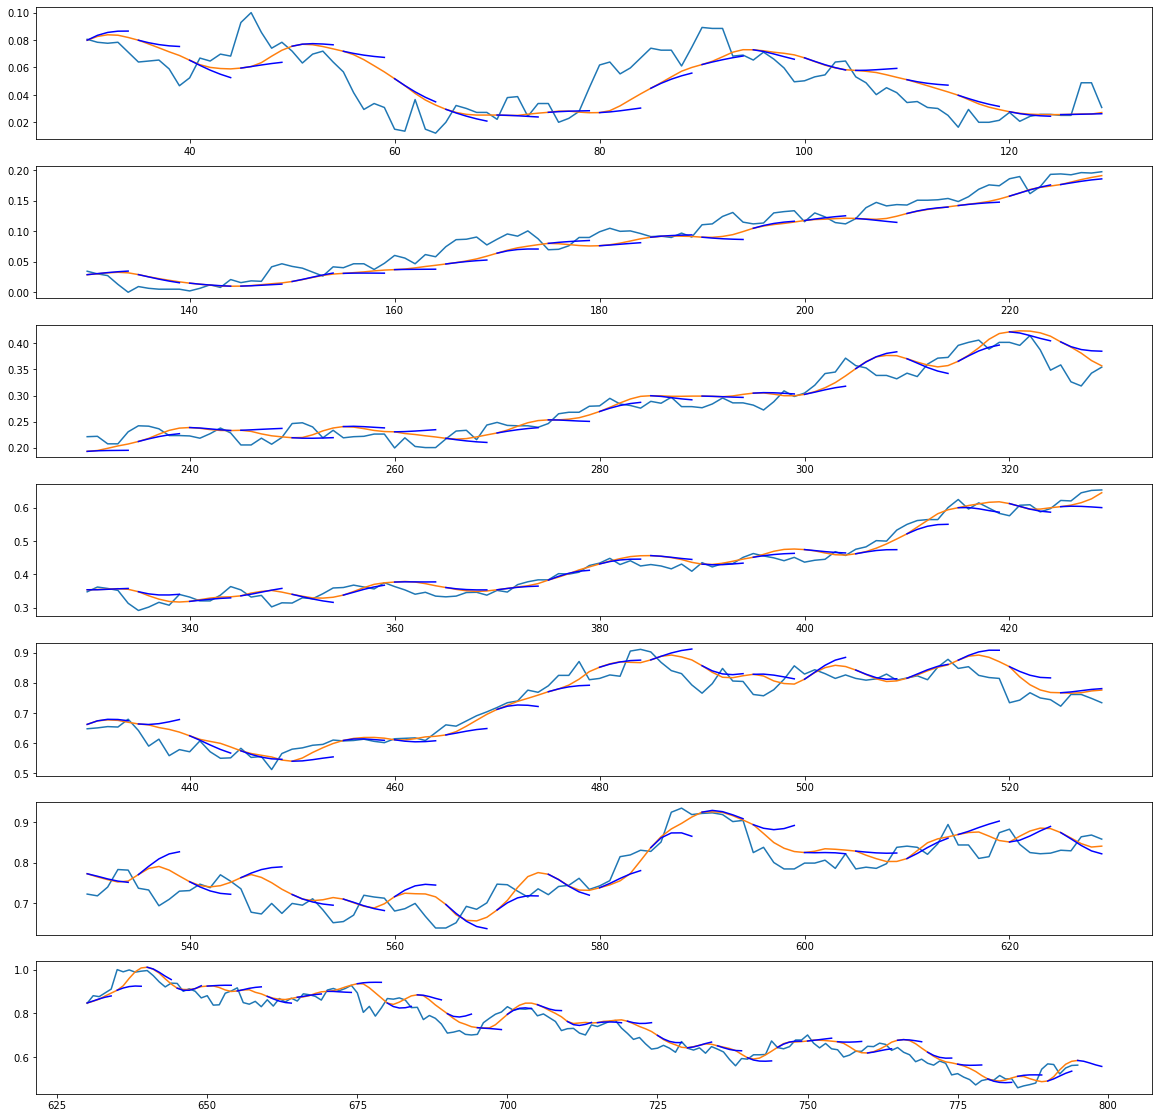

In [24]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)

# plt.plot(target_train_np[:,1])
# plt.plot(predictions_train[:,0,1])
view_plot(predictions_train, target_train_np)

<Figure size 1440x1440 with 0 Axes>

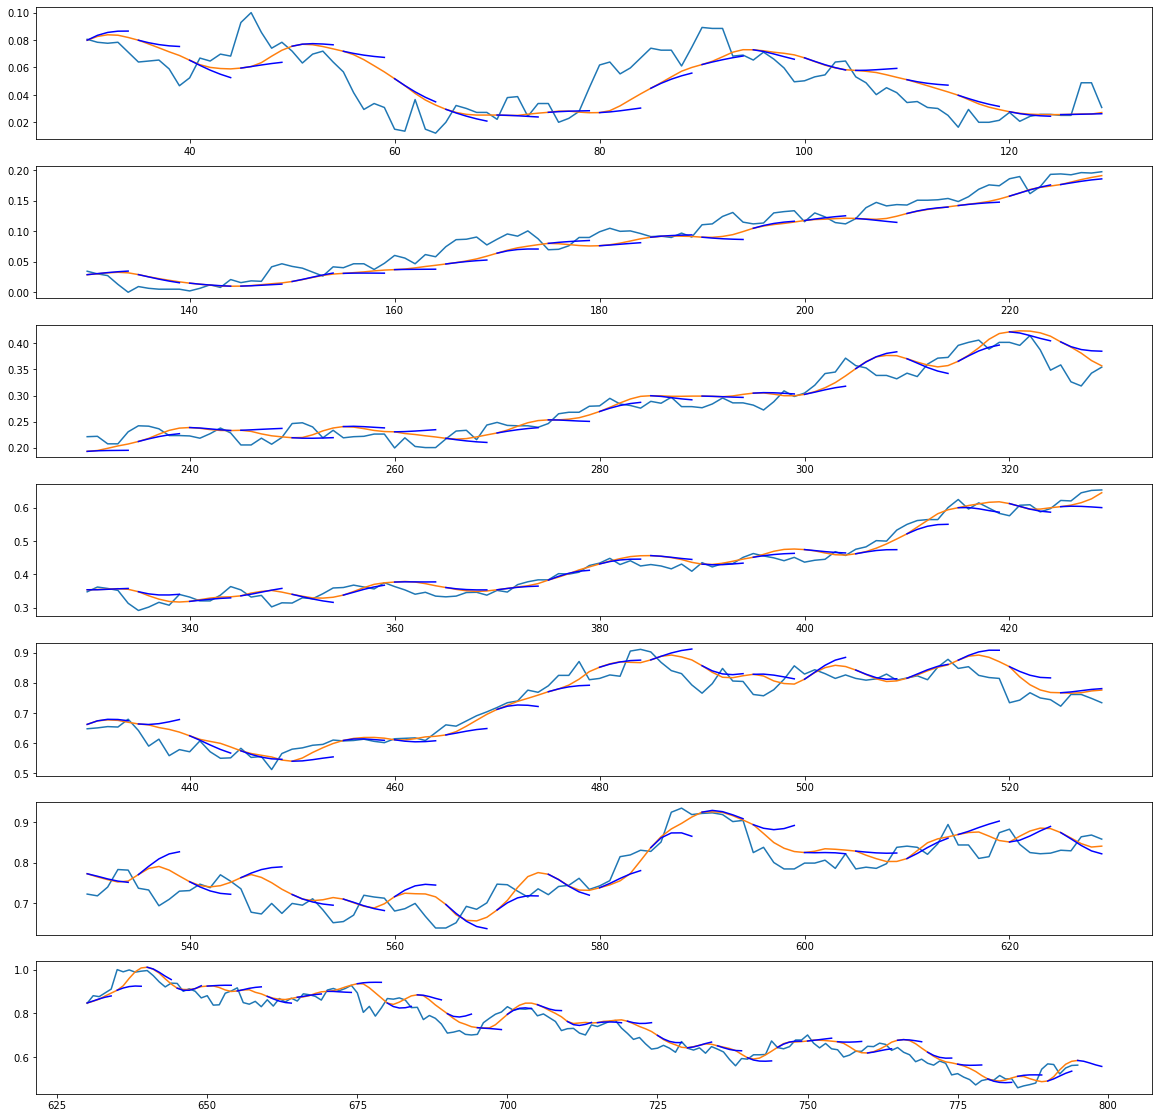

In [19]:
loss_train, predictions_train = evaluate(time_steps, foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 1
#plt.figure(figsize=(100, 5))

view_plot(predictions_train, target_train_np)

# ax = []
# for i in range(7):
#   ax.append(fig.add_subplot(7,1,i+1)) 

# step = 100
# for i in range(1,8):
#   start = (i-1) * step

#   if i == 7: end = predictions_train.shape[0]
#   else: end = i * step

#  # try:
#   ax[i-1].plot(target_train_np[0:,0][start:end],target_train_np[0:,1][start:end])
#   ax[i-1].plot(predictions_train[:,0,0][start:end],predictions_train[:,0,1][start:end])
#   for j in range(start, end):
#     if j%foresee_date == 0:
#       ax[i-1].plot(predictions_train[:,:,0][j],predictions_train[:,:,1][j], color = 'b')
  #except: print(i)

#plt.plot(predictions_train[:,:,0],predictions_train[:,:,1])

In [20]:
#print(target_train_np[d - 1:,1])
#print(predictions_train[:,d-1,1])
#print(pre_with_time)
print(predictions_train[:,:,1][:100])
print(predictions_train[:,:,0][0])
#print(predictions_train[:2,:,1])
print(predictions_train.shape[0])

[[0.0798624  0.08339516 0.08552468 0.08642343 0.08650042]
 [0.08259514 0.08338238 0.08276015 0.08137861 0.07977532]
 [0.08380167 0.08376419 0.0829098  0.08172118 0.08056776]
 [0.08348916 0.08207807 0.08014651 0.07819614 0.07654545]
 [0.08185194 0.07959006 0.07732612 0.0754153  0.07399542]
 [0.07985227 0.07803725 0.0766517  0.07575276 0.07529196]
 [0.07712395 0.0742492  0.07170846 0.06968232 0.06817838]
 [0.07430339 0.07175602 0.06961486 0.0679213  0.06665751]
 [0.07140904 0.06884925 0.06688197 0.06549598 0.06457053]
 [0.06874888 0.06657172 0.06490462 0.06367479 0.06278417]
 [0.06528454 0.06154371 0.05807989 0.05509937 0.05263613]
 [0.06202873 0.05924949 0.05687789 0.0548844  0.05324494]
 [0.06007499 0.05915198 0.05888051 0.05897461 0.05924533]
 [0.05924925 0.05911297 0.05931503 0.0596566  0.06003303]
 [0.05897916 0.0589976  0.05919558 0.05948358 0.05979006]
 [0.05957861 0.06067148 0.06183516 0.06288464 0.06376892]
 [0.06067345 0.06229441 0.06449204 0.066966   0.06934463]
 [0.0635428  0

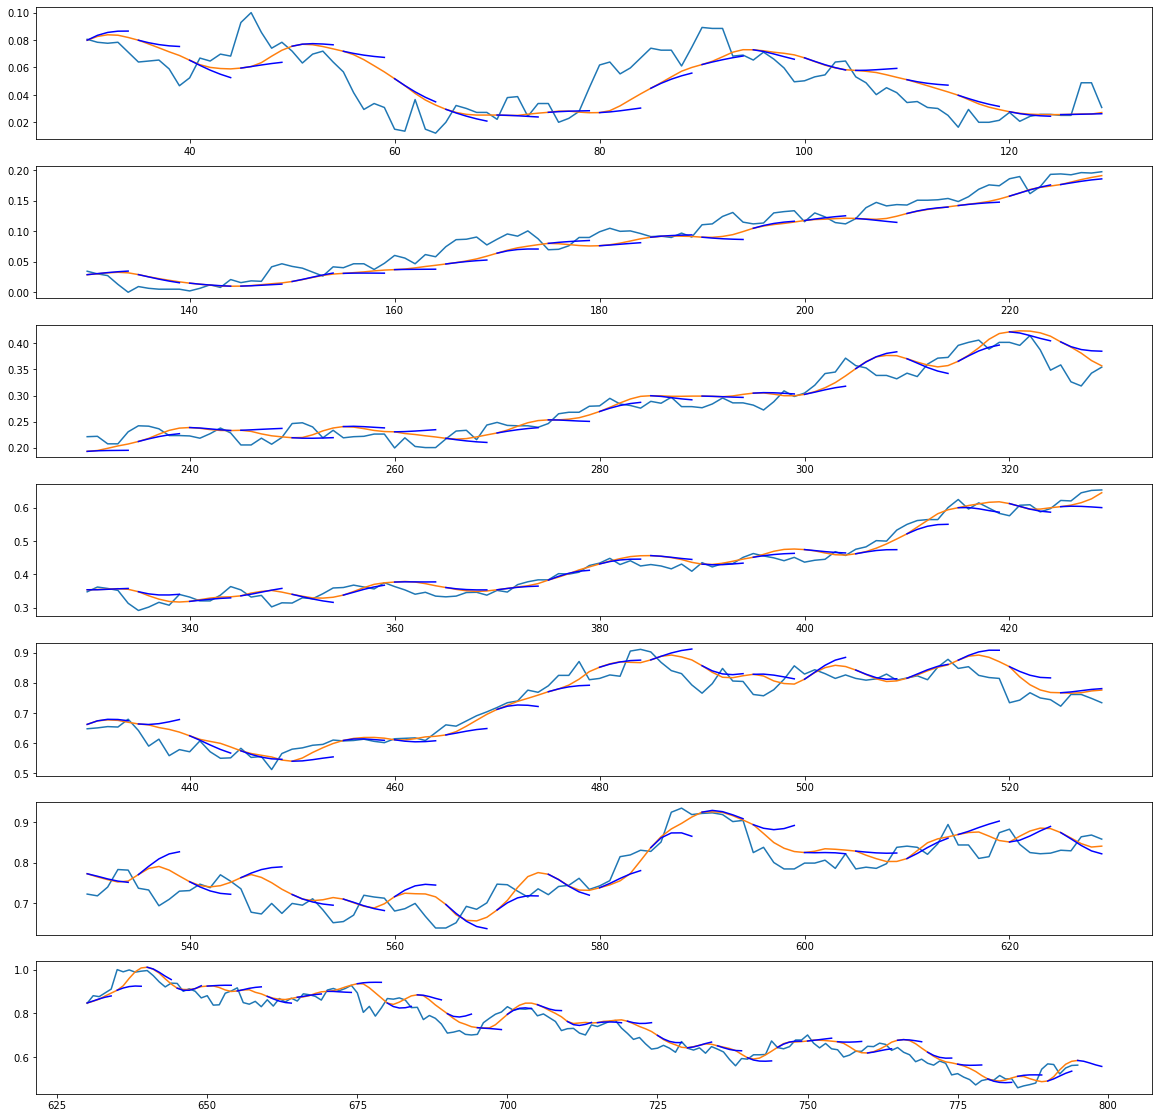

In [21]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5
view_plot(predictions_train, target_train_np)
# plt.plot(target_train_np[d - 1:,1])
# plt.plot(predictions_train[:,d - 1,1])

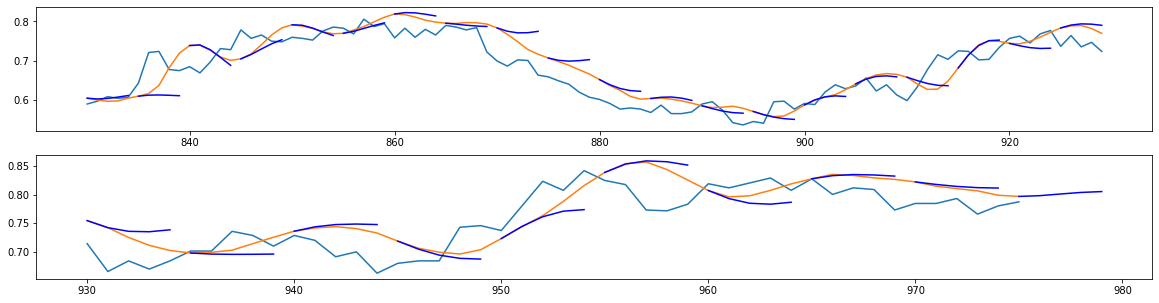

In [31]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 1

view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [32]:
predictions_val.shape

(146, 5, 2)

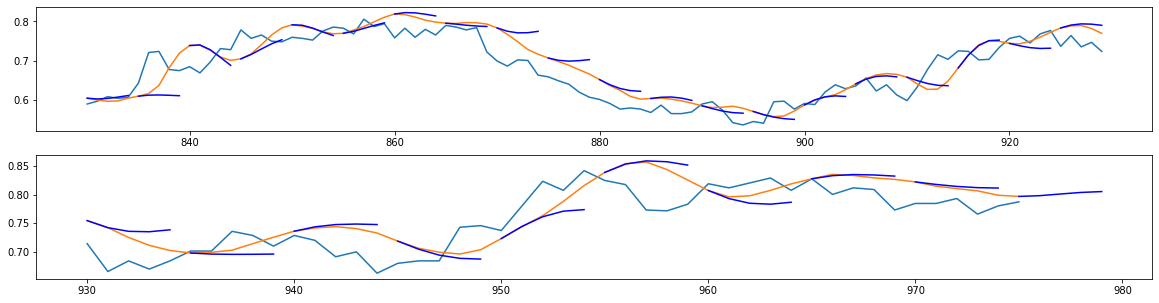

In [34]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 5
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [36]:
optimizer = optim.Adam(model.parameters(), lr = lr/3)

for ep in range(200):
  start_time = time.time()
  if shuffle:
    random.shuffle(train_batches)
  train_loss = train(time_steps,foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)



0.002925202834839168
0.003026093883776058
0.002793011348075266
0.0028783943972670203


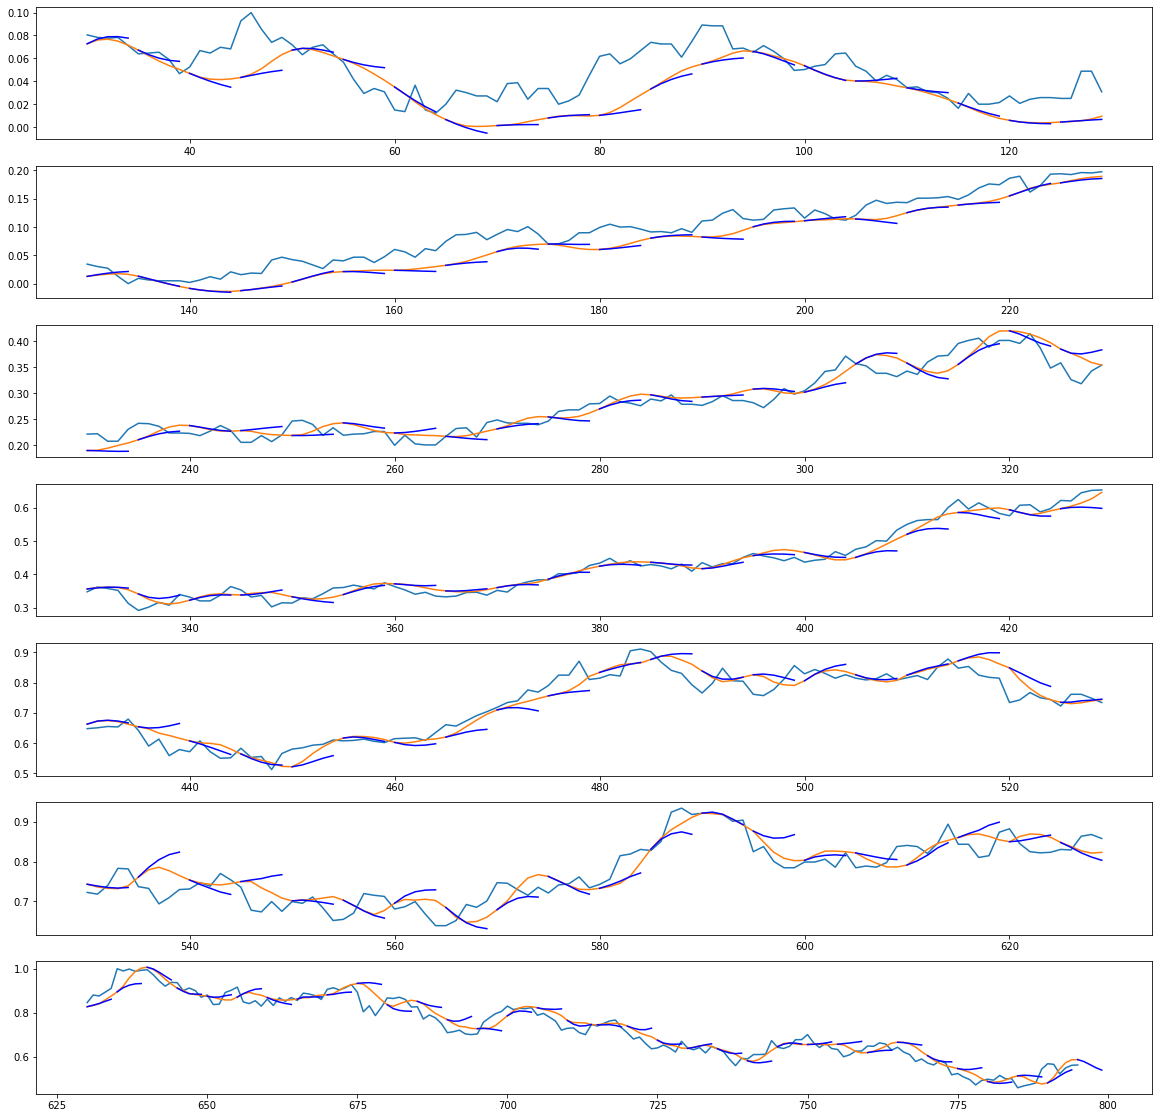

In [42]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 1
view_plot(predictions_train, target_train_np)
# plt.plot(target_train_np[d - 1:,1])
# plt.plot(predictions_train[:,d - 1,1])

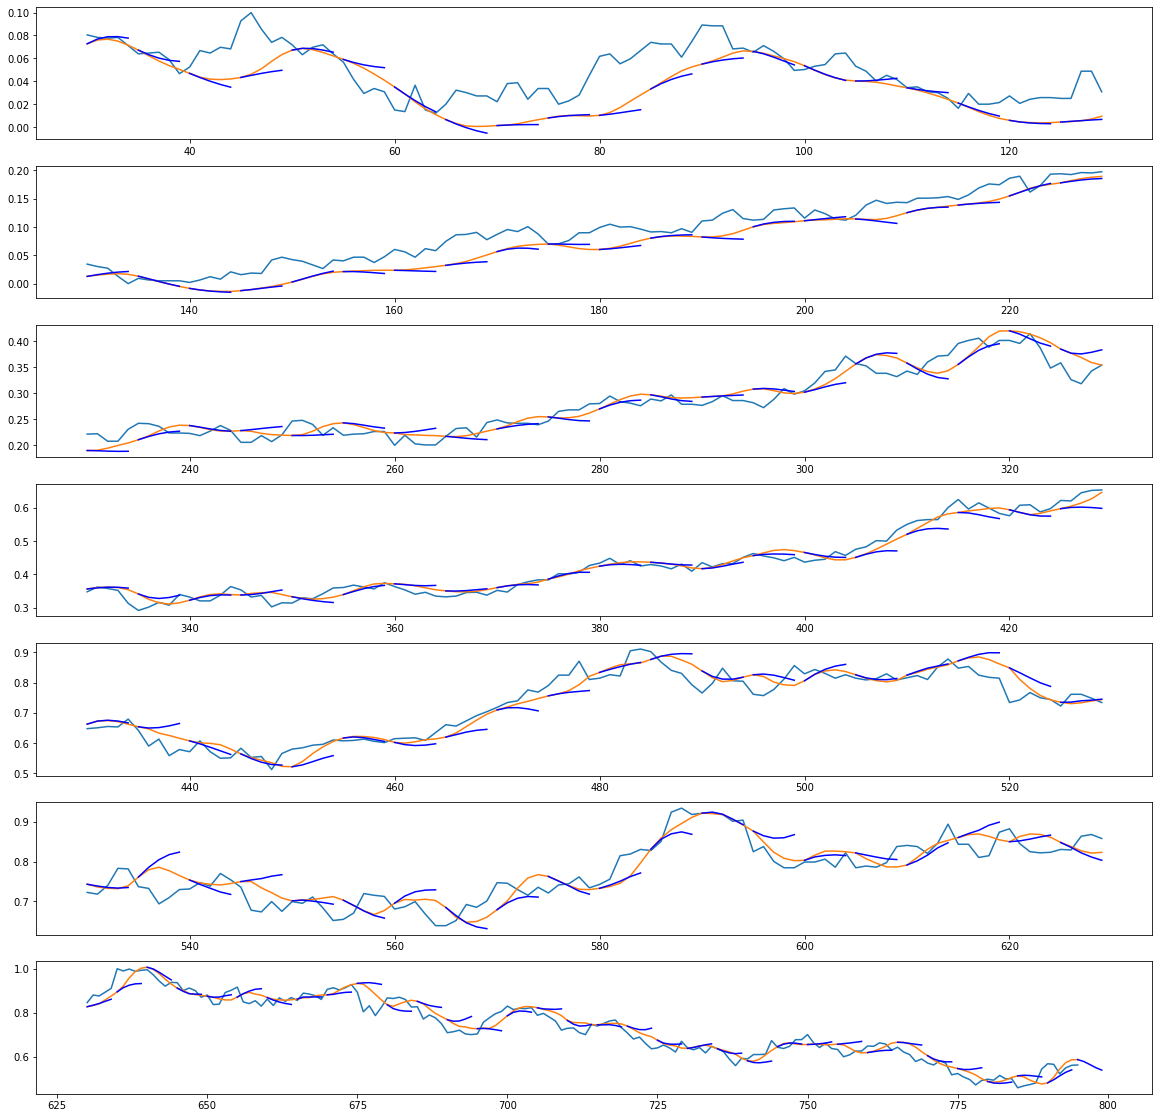

In [44]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5
view_plot(predictions_train, target_train_np)


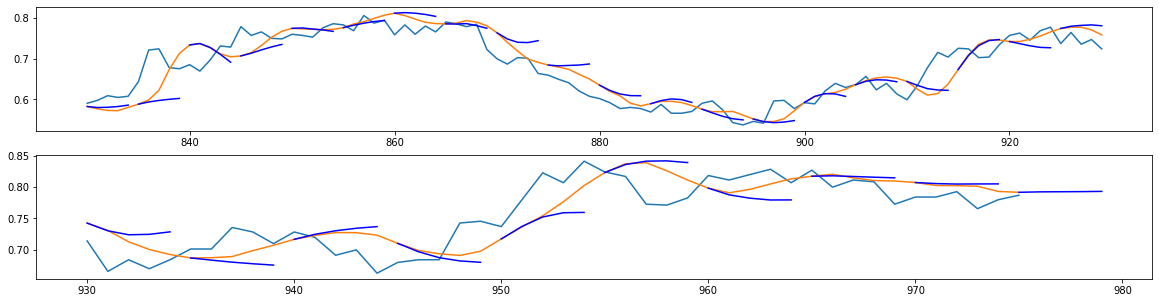

In [46]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 1
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

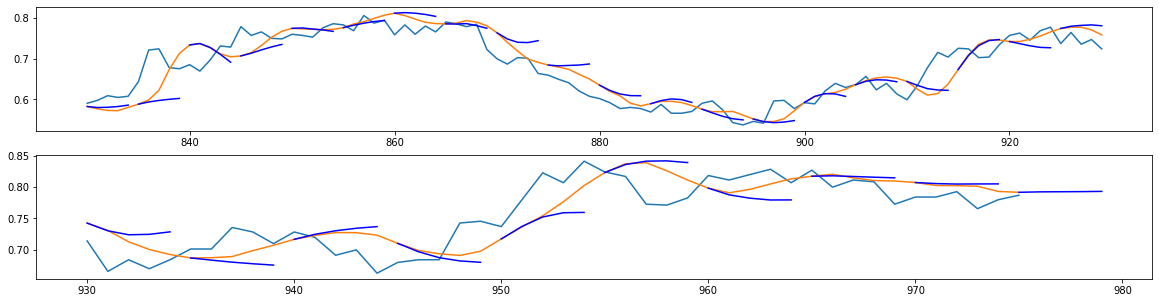

In [48]:
loss_val, predictions_val = evaluate(time_steps,foresee_date, data_val_tensor, target_val_tensor, model, criterion)

d = 5
view_plot_val(predictions_val, target_val_np)
# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])

In [53]:
optimizer = optim.Adam(model.parameters(), lr = lr/5)

for ep in range(200):
  start_time = time.time()
  train_loss = train(time_steps,foresee_date, train_batches, model, optimizer, criterion)
  end_time = time.time()
  if ep%50 == 0:
    print(train_loss)

0.0026966420264925156
0.0026806558607117147
0.002708224611181056
0.0026231296187406972


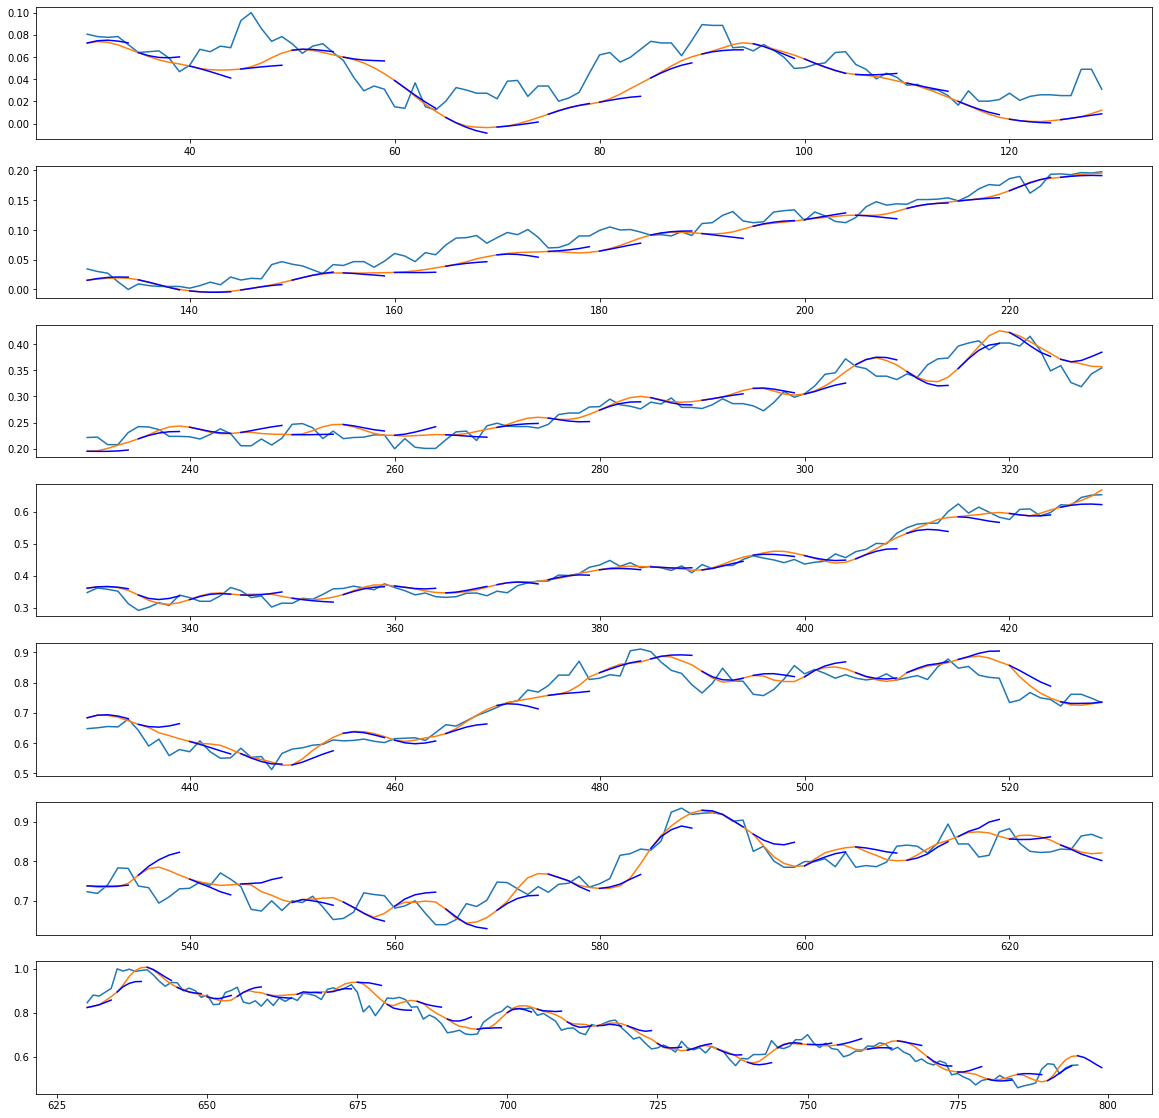

In [54]:
loss_train, predictions_train = evaluate(time_steps,foresee_date, data_train_tensor, target_train_tensor, model, criterion)

d = 5

# print(predictions_train.shape)
# print(target_train_np.shape)

# plt.plot(target_train_np[d - 1:,1][300:500])
# plt.plot(predictions_train[:,d - 1,1][300:500])

# print(target_train_np[d - 1,0])
# print(predictions_train[0,d-1,0])
view_plot(predictions_train, target_train_np)


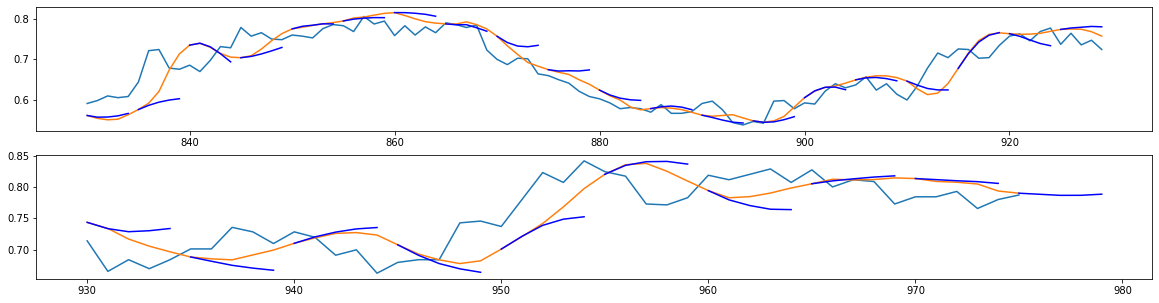

In [56]:
loss_val, predictions_val = evaluate(time_steps, foresee_date,data_val_tensor, target_val_tensor, model, criterion)

# d = 5

# plt.plot(target_val_np[d - 1:,1])
# plt.plot(predictions_val[:,d - 1,1])
view_plot_val(predictions_val, target_val_np)
